In [1]:
# !pip install transformers

In [2]:
%matplotlib inline

In [3]:
import torch
from transformers import BertTokenizer, BertModel

import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
tokenizer

In [5]:
text = "The financial performance of the company was average overall, but revenue spiked by a lot " \
       "There was a dip in the net profit margin"

In [6]:
text

'The financial performance of the company was average overall, but revenue spiked by a lot There was a dip in the net profit margin'

In [7]:
# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

count = 0
# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))
    count += 1
print(count)

[CLS]           101
the           1,996
financial     3,361
performance   2,836
of            1,997
the           1,996
company       2,194
was           2,001
average       2,779
overall       3,452
,             1,010
but           2,021
revenue       6,599
spiked       25,362
by            2,011
a             1,037
lot           2,843
there         2,045
was           2,001
a             1,037
dip          16,510
in            1,999
the           1,996
net           5,658
profit        5,618
margin        7,785
[SEP]           102
27


In [8]:
# Mark each of the 27 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print(segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [9]:
len(segments_ids)

27

In [10]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [11]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [12]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [13]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 27
Number of hidden units: 768


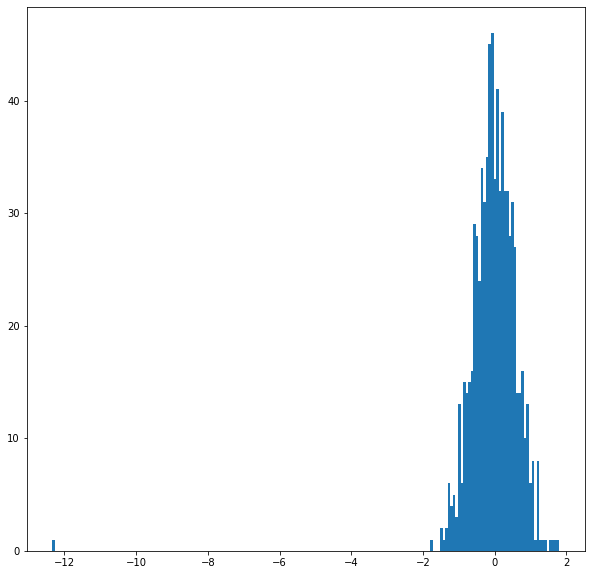

In [14]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [15]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 27, 768])


In [16]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 27, 768])

In [17]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 27, 768])

In [18]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([27, 13, 768])

In [19]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 27 x 3072


In [20]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 27 x 768


In [21]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [22]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


In [23]:
sentence_embedding

tensor([-7.4926e-01, -4.5831e-01, -3.0521e-02,  2.6990e-01, -2.7917e-01,
        -9.0261e-02, -3.3638e-01,  6.3047e-01, -1.3263e-01,  1.3970e-01,
         5.0323e-01, -2.2278e-01,  6.3738e-01,  5.1268e-01, -4.9032e-01,
        -1.4126e-01, -1.3073e-01, -3.9658e-01,  3.9287e-01, -5.4723e-02,
        -2.8942e-01,  1.5683e-01, -4.5321e-02,  5.1924e-01,  1.1278e-01,
        -2.3115e-02,  8.8244e-02,  6.7115e-02, -8.0355e-01, -4.5642e-01,
         4.7945e-01,  3.2196e-01, -3.4401e-01, -3.3807e-01,  3.0307e-01,
        -5.2028e-02,  1.2496e-01, -3.7958e-01, -5.1109e-01, -2.4140e-01,
        -5.3661e-01, -9.5835e-02,  1.4447e-01, -5.7779e-02, -3.5680e-01,
        -3.0390e-01,  3.9665e-02, -2.0789e-01, -6.4492e-02, -4.1587e-01,
        -7.0349e-01,  8.9466e-02,  1.4649e-01, -5.7112e-01, -5.8508e-01,
         3.2613e-01, -1.6048e-01,  7.7892e-02, -6.1548e-01,  3.0104e-01,
         4.7676e-01, -6.6555e-01, -4.2913e-01, -4.8584e-01, -3.2862e-01,
        -4.1358e-01,  6.1551e-01,  5.9599e-01, -5.9

In [24]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 the
2 financial
3 performance
4 of
5 the
6 company
7 was
8 average
9 overall
10 ,
11 but
12 revenue
13 spiked
14 by
15 a
16 lot
17 there
18 was
19 a
20 dip
21 in
22 the
23 net
24 profit
25 margin
26 [SEP]


In [25]:
print('First 5 vector values for "revenue", "profit" and "margin" are:')
print('')
print("revenue   ", str(token_vecs_sum[12][:5]))
print("profit  ", str(token_vecs_sum[24][:5]))
print("margin   ", str(token_vecs_sum[25][:5]))

First 5 vector values for "revenue", "profit" and "margin" are:

revenue    tensor([ 1.0783, -0.0221,  2.7635, -0.0498,  2.1201])
profit   tensor([ 0.8338, -0.5861,  2.2561,  1.6393,  0.5799])
margin    tensor([-0.7424, -3.2827,  0.3892,  0.7105, -2.7882])


In [26]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word revenue and profit
one = 1 - cosine(token_vecs_sum[12], token_vecs_sum[24])

# Calculate the cosine similarity between the word revenue and margin
two = 1 - cosine(token_vecs_sum[12], token_vecs_sum[25])

print('Vector similarity:  %.2f' % one)
print('Vector similarity:  %.2f' % two)

Vector similarity:  0.70
Vector similarity:  0.50


(Image from [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)